In [1]:
# ===== CELDA 0: Setup MLflow (EJECUTAR PRIMERA) =====
import mlflow
from pathlib import Path

# Limpiar cualquier configuración previa
mlflow.end_run()

# Configurar tracking URI a raíz del proyecto
project_root = Path("/Users/santiagoamaya/Desktop/propAgent/real-estate-ai-finder")
tracking_uri = f"file://{project_root}/mlruns"
mlflow.set_tracking_uri(tracking_uri)

print(f"✅ Tracking URI: {tracking_uri}")

# Crear experimento fotocasa_eda
experiment_name = "fotocasa_eda"
try:
    exp_id = mlflow.create_experiment(experiment_name)
    print(f"✅ Experimento '{experiment_name}' creado (ID: {exp_id})")
except:
    exp = mlflow.get_experiment_by_name(experiment_name)
    exp_id = exp.experiment_id
    print(f"✅ Usando experimento '{experiment_name}' (ID: {exp_id})")

mlflow.set_experiment(experiment_name)
print("✅ Setup completo!")

✅ Tracking URI: file:///Users/santiagoamaya/Desktop/propAgent/real-estate-ai-finder/mlruns
✅ Usando experimento 'fotocasa_eda' (ID: 555527120249116419)
✅ Setup completo!


In [ ]:
# CELDA 0.5: Setup de directorios de output
from pathlib import Path

# Directorios relativos a la raíz del proyecto
project_root = Path("/Users/santiagoamaya/Desktop/propAgent/real-estate-ai-finder")

# Crear estructura de reports
REPORTS_DIR = project_root / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
METRICS_DIR = REPORTS_DIR / "metrics"
ANALYSIS_DIR = REPORTS_DIR / "analysis"

# Crear si no existen
for dir_path in [FIGURES_DIR, METRICS_DIR, ANALYSIS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("✅ Directorios de output configurados:")
print(f"   Figures: {FIGURES_DIR}")
print(f"   Metrics: {METRICS_DIR}")
print(f"   Analysis: {ANALYSIS_DIR}")

In [2]:
# Cell 1: Imports y configuración
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

import mlflow
import mlflow.data
from mlflow import MlflowClient

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Setup complete")
print(f"📊 MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"🔬 Current experiment: fotocasa_eda")

✅ Setup complete
📊 MLflow tracking URI: file:///Users/santiagoamaya/Desktop/propAgent/real-estate-ai-finder/mlruns
🔬 Current experiment: fotocasa_eda


In [3]:
# Cell 2: Cargar todos los datos scrapeados
from glob import glob

# Encontrar todos los JSONs
json_files = sorted(Path('../data/raw').glob('fotocasa_*.json'))
print(f"Found {len(json_files)} data files:\n")

all_properties = []
metadata_list = []

for json_file in json_files:
    with open(json_file) as f:
        data = json.load(f)
        properties = data.get('properties', [])
        metadata = data.get('metadata', {})
        
        # Añadir info de archivo
        for prop in properties:
            prop['data_file'] = json_file.name
            prop['scraped_date'] = json_file.stem.split('_')[1]  # YYYYMMDD
        
        all_properties.extend(properties)
        metadata_list.append({
            'file': json_file.name,
            'properties': len(properties),
            **metadata.get('scraping', {}),
            **metadata.get('statistics', {})
        })
        
        print(f"  {json_file.name}: {len(properties)} properties")

print(f"\n📊 Total properties: {len(all_properties)}")

# Crear DataFrame
df = pd.DataFrame(all_properties)
metadata_df = pd.DataFrame(metadata_list)

print(f"✅ Data loaded: {df.shape}")

Found 5 data files:

  fotocasa_20251119_170227.json: 60 properties
  fotocasa_20251119_204000.json: 60 properties
  fotocasa_20251123_153811.json: 30 properties
  fotocasa_20251123_154917.json: 6 properties
  fotocasa_20251123_203929.json: 6 properties

📊 Total properties: 162
✅ Data loaded: (162, 15)


In [4]:
# Cell 3: Log info básica en MLflow
with mlflow.start_run(run_name="initial_data_exploration"):
    
    # Log parámetros básicos
    mlflow.log_param("num_files", len(json_files))
    mlflow.log_param("total_properties", len(df))
    mlflow.log_param("date_range", f"{json_files[0].stem} to {json_files[-1].stem}")
    
    # Log métricas de tamaño
    mlflow.log_metric("properties_per_file_avg", len(df) / len(json_files))
    mlflow.log_metric("unique_locations", df['location'].nunique())
    
    # Log distribución de tipos
    for col in ['rooms', 'bathrooms']:
        if col in df.columns:
            mlflow.log_metric(f"{col}_mean", df[col].mean())
    
    print("✅ Logged to MLflow")

✅ Logged to MLflow


In [5]:
# Cell 4: Análisis de calidad de datos (critical!)
print("📊 DATA QUALITY ANALYSIS\n" + "="*60)

# Completeness por campo
completeness = {}
for col in df.columns:
    non_null = df[col].notna().sum()
    completeness[col] = {
        'count': non_null,
        'percentage': (non_null / len(df)) * 100
    }

# Crear DataFrame de calidad
quality_df = pd.DataFrame(completeness).T
quality_df = quality_df.sort_values('percentage', ascending=False)

print("\nCompleteness por campo:")
print(quality_df[quality_df['percentage'] < 100])

# Métricas críticas
critical_fields = ['price', 'location', 'images', 'description']
print(f"\n🎯 Critical fields completeness:")
for field in critical_fields:
    if field in quality_df.index:
        pct = quality_df.loc[field, 'percentage']
        icon = "✅" if pct > 95 else "⚠️" if pct > 80 else "❌"
        print(f"  {icon} {field}: {pct:.1f}%")

# Imágenes
print(f"\n🖼️ Image statistics:")
df['num_images'] = df['images'].apply(lambda x: len(x) if isinstance(x, list) else 0)
print(f"  Properties with images: {(df['num_images'] > 0).sum()} ({(df['num_images'] > 0).sum()/len(df)*100:.1f}%)")
print(f"  Avg images per property: {df['num_images'].mean():.1f}")
print(f"  Max images: {df['num_images'].max()}")

📊 DATA QUALITY ANALYSIS

Completeness por campo:
           count  percentage
size_m2     42.0   25.925926
rooms       42.0   25.925926
bathrooms   42.0   25.925926

🎯 Critical fields completeness:
  ✅ price: 100.0%
  ✅ location: 100.0%
  ✅ images: 100.0%
  ✅ description: 100.0%

🖼️ Image statistics:
  Properties with images: 162 (100.0%)
  Avg images per property: 32.3
  Max images: 120


💰 Price per m²:
  Median: 5996€/m²
  Mean: 6256€/m²


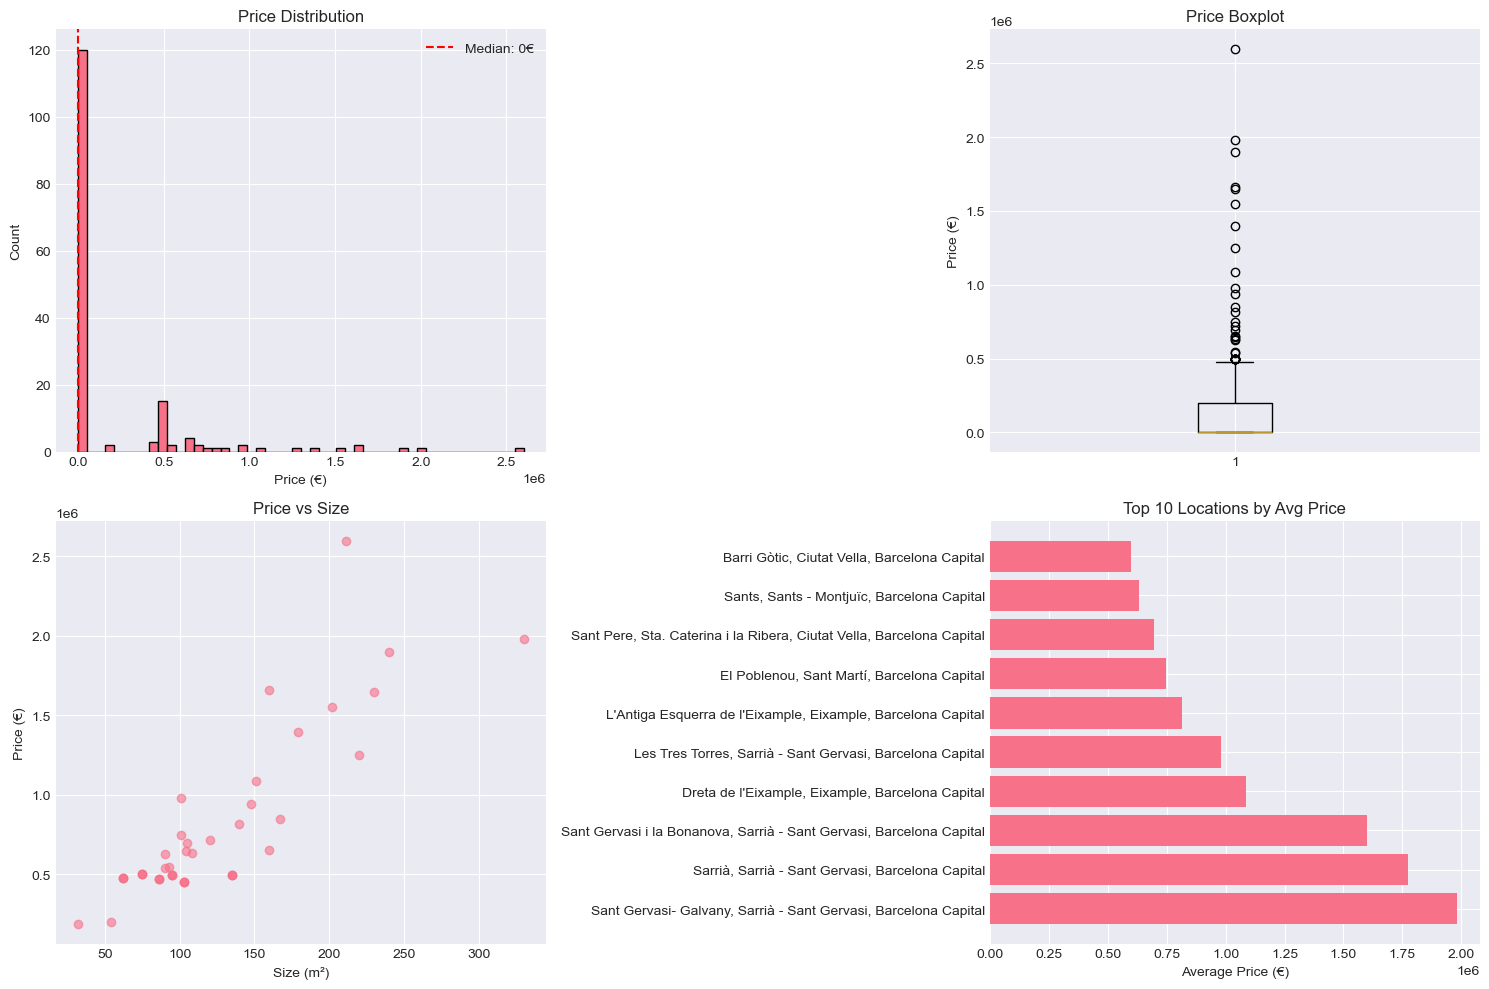

In [ ]:
# Cell 5: Análisis de precios
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de precios
axes[0, 0].hist(df['price'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].axvline(df['price'].median(), color='red', linestyle='--', label=f'Median: {df["price"].median():,.0f}€')
axes[0, 0].legend()

# Boxplot de precios
axes[0, 1].boxplot(df['price'])
axes[0, 1].set_ylabel('Price (€)')
axes[0, 1].set_title('Price Boxplot')

# Price vs Size (si existe size_m2)
if 'size_m2' in df.columns and df['size_m2'].notna().sum() > 0:
    valid_data = df.dropna(subset=['size_m2', 'price']).copy()
    axes[1, 0].scatter(valid_data['size_m2'], valid_data['price'], alpha=0.6)
    axes[1, 0].set_xlabel('Size (m²)')
    axes[1, 0].set_ylabel('Price (€)')
    axes[1, 0].set_title('Price vs Size')
    
    # Calcular precio por m²
    valid_data['price_per_m2'] = valid_data['price'] / valid_data['size_m2']
    print(f"💰 Price per m²:")
    print(f"  Median: {valid_data['price_per_m2'].median():.0f}€/m²")
    print(f"  Mean: {valid_data['price_per_m2'].mean():.0f}€/m²")

# Top locations por precio medio
top_locations = df.groupby('location')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
axes[1, 1].barh(range(len(top_locations)), top_locations['mean'])
axes[1, 1].set_yticks(range(len(top_locations)))
axes[1, 1].set_yticklabels(top_locations.index)
axes[1, 1].set_xlabel('Average Price (€)')
axes[1, 1].set_title('Top 10 Locations by Avg Price')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'price_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Log a MLflow
mlflow.log_artifact(str(FIGURES_DIR / 'price_analysis.png'))

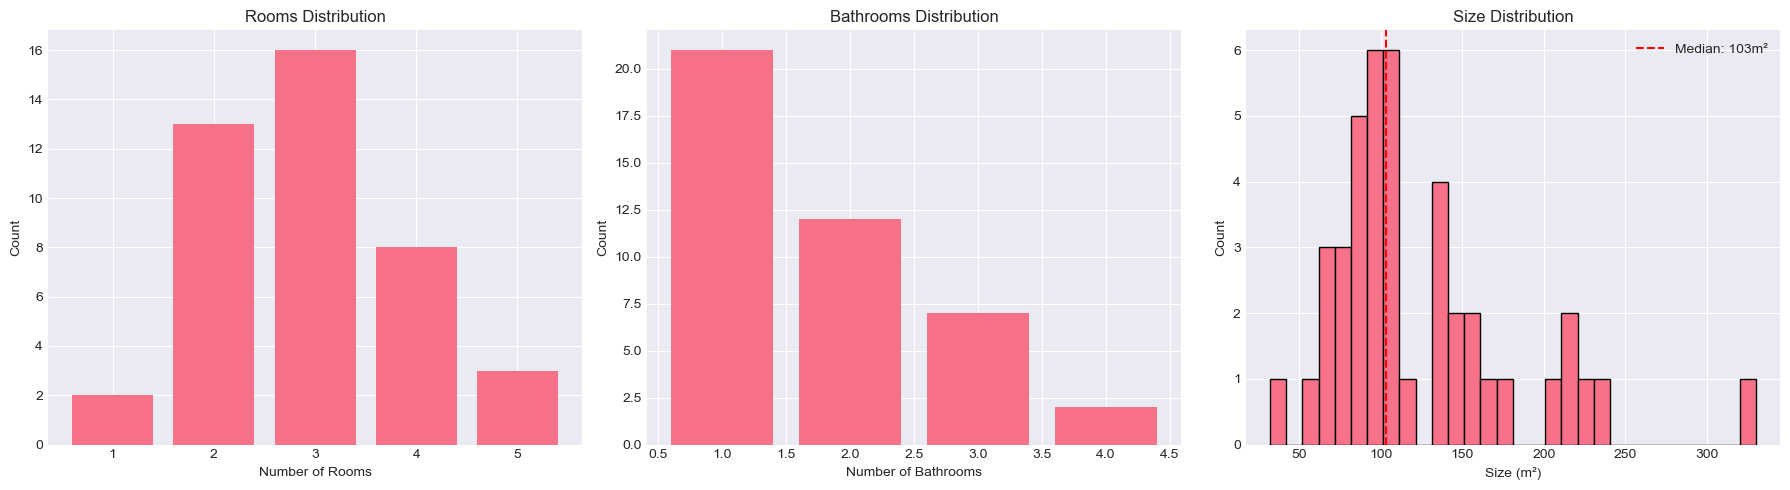

In [ ]:
# Cell 6: Análisis de características
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rooms distribution
if 'rooms' in df.columns:
    rooms_dist = df['rooms'].value_counts().sort_index()
    axes[0].bar(rooms_dist.index, rooms_dist.values)
    axes[0].set_xlabel('Number of Rooms')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Rooms Distribution')

# Bathrooms distribution  
if 'bathrooms' in df.columns:
    bath_dist = df['bathrooms'].value_counts().sort_index()
    axes[1].bar(bath_dist.index, bath_dist.values)
    axes[1].set_xlabel('Number of Bathrooms')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Bathrooms Distribution')

# Size distribution
if 'size_m2' in df.columns:
    size_data = df['size_m2'].dropna()
    axes[2].hist(size_data, bins=30, edgecolor='black')
    axes[2].set_xlabel('Size (m²)')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Size Distribution')
    axes[2].axvline(size_data.median(), color='red', linestyle='--', label=f'Median: {size_data.median():.0f}m²')
    axes[2].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'features_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

mlflow.log_artifact(str(FIGURES_DIR / 'features_analysis.png'))

In [8]:
# Cell 7: Análisis de descripciones (preparación para NLP en Fase 2)
from collections import Counter
import re

# Filtrar descripciones válidas
valid_descriptions = df[df['description'].notna() & (df['description'] != '')]['description']

print(f"📝 Description Analysis:")
print(f"  Total properties with description: {len(valid_descriptions)} ({len(valid_descriptions)/len(df)*100:.1f}%)")

# Longitud de descripciones
desc_lengths = valid_descriptions.str.len()
print(f"  Avg description length: {desc_lengths.mean():.0f} chars")
print(f"  Median: {desc_lengths.median():.0f} chars")

# Palabras clave relevantes para tu proyecto (indirect filters)
keywords = [
    'entrada independiente', 'entrada propia', 'acceso independiente',
    'luz natural', 'muy luminoso', 'exterior',
    'dos ambientes', 'espacios separados', 'diáfano',
    'local comercial', 'uso comercial', 'actividad comercial',
    'parking', 'terraza', 'balcón'
]

keyword_counts = {}
for keyword in keywords:
    count = valid_descriptions.str.lower().str.contains(keyword).sum()
    if count > 0:
        keyword_counts[keyword] = count
        percentage = (count / len(valid_descriptions)) * 100
        print(f"  '{keyword}': {count} ({percentage:.1f}%)")

# Log a MLflow
with mlflow.start_run(run_name="text_analysis", nested=True):
    mlflow.log_metric("descriptions_with_text", len(valid_descriptions))
    mlflow.log_metric("avg_description_length", desc_lengths.mean())
    
    for keyword, count in keyword_counts.items():
        mlflow.log_metric(f"keyword_{keyword.replace(' ', '_')}", count)

📝 Description Analysis:
  Total properties with description: 162 (100.0%)
  Avg description length: 1777 chars
  Median: 1761 chars
  'luz natural': 54 (33.3%)
  'muy luminoso': 9 (5.6%)
  'exterior': 64 (39.5%)
  'dos ambientes': 7 (4.3%)
  'diáfano': 2 (1.2%)
  'local comercial': 4 (2.5%)
  'parking': 21 (13.0%)
  'terraza': 51 (31.5%)
  'balcón': 46 (28.4%)


In [ ]:
mlflow.end_run()  # Cerrar cualquier run anterior
# Cell 8: Log comprehensive summary a MLflow
with mlflow.start_run(run_name="eda_summary"):
    
    # Parámetros del dataset
    mlflow.log_param("dataset_date", datetime.now().strftime("%Y-%m-%d"))
    mlflow.log_param("total_files", len(json_files))
    mlflow.log_param("analysis_version", "v1.0")
    
    # Métricas de tamaño
    mlflow.log_metric("total_properties", len(df))
    mlflow.log_metric("unique_locations", df['location'].nunique())
    
    # Métricas de calidad
    mlflow.log_metric("completeness_price", (df['price'].notna().sum() / len(df)) * 100)
    mlflow.log_metric("completeness_images", (df['num_images'] > 0).sum() / len(df) * 100)
    mlflow.log_metric("completeness_description", (df['description'].notna().sum() / len(df)) * 100)
    
    # Estadísticas de precio
    mlflow.log_metric("price_mean", df['price'].mean())
    mlflow.log_metric("price_median", df['price'].median())
    mlflow.log_metric("price_std", df['price'].std())
    mlflow.log_metric("price_min", df['price'].min())
    mlflow.log_metric("price_max", df['price'].max())
    
    # Features
    if 'size_m2' in df.columns:
        valid_size = df['size_m2'].dropna()
        mlflow.log_metric("size_mean", valid_size.mean())
        mlflow.log_metric("size_median", valid_size.median())
    
    if 'rooms' in df.columns:
        mlflow.log_metric("rooms_mean", df['rooms'].mean())
        mlflow.log_metric("rooms_mode", df['rooms'].mode()[0])
    
    # Log artifacts
    mlflow.log_artifact('../reports/price_analysis.png')
    mlflow.log_artifact('../reports/features_analysis.png')
    
    # Log dataset as artifact
    df.to_csv(METRICS_DIR / 'eda_dataset.csv', index=False)
    mlflow.log_artifact(str(METRICS_DIR / 'eda_dataset.csv'))

    mlflow.log_artifact(str(FIGURES_DIR / 'price_analysis.png'))
    mlflow.log_artifact(str(FIGURES_DIR / 'features_analysis.png'))
    
    print("✅ Summary logged to MLflow")
    print(f"🔗 View at:  http://127.0.0.1:5000")

✅ Summary logged to MLflow
🔗 View at: http://localhost:5000
